# 1. Webscraping

Importación de librerías

In [1]:
import time
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchElementException, ElementNotInteractableException
import pandas as pd
from datetime import datetime, timedelta
import chromedriver_autoinstaller
import random
import re

Extracción de información de la web

In [2]:
date = datetime.today() - timedelta(0)
inicio=time.time()

####################### ENTRADA A LA PÁGINA
chromedriver_autoinstaller.install()

options = webdriver.ChromeOptions()
driver = webdriver.Chrome( options = options )

######################## WEBSCRAPING 
driver.get('https://www.goodreads.com/book/show/50494784/reviews') #Acá se puede poner la URL de interés

filtro = WebDriverWait(driver, 10).until(
    EC.element_to_be_clickable((By.XPATH, '//*[@id="__next"]/div[2]/main/div[1]/div[2]/div[4]/div[1]/div[2]/div/button'))
)
filtro.click() 

time.sleep(random.uniform(3, 5))

condicion=driver.find_element(By.XPATH,'/html/body/div[3]/div/div[2]/span/div/div[6]/div[3]') #Idioma1 
condicion.click()

aplicar_filtro = WebDriverWait(driver, 10).until(
    EC.element_to_be_clickable((By.XPATH, '/html/body/div[3]/div/div[3]/div[2]/button'))
)
aplicar_filtro.click()

time.sleep(random.uniform(1, 5))

obra=driver.find_element(By.XPATH,'//*[@id="__next"]/div[2]/main/div[1]/div[2]/div[1]/div[2]/h1[2]')
autor=driver.find_element(By.XPATH,'//*[@id="__next"]/div[2]/main/div[1]/div[2]/div[1]/div[2]/h3/div/span[1]/a')
lista_obra=obra.text
lista_autor=autor.text
# Identificar cuantos click tiene que hacer

auxiliar=driver.find_element(By.XPATH,'//*[@id="__next"]/div[2]/main/div[1]/div[2]/div[5]/div[3]/span')
cadena=auxiliar.text

patron = r"(\d[\d,]*) reviews"
resultado = re.search(patron, cadena)
num_opiniones=resultado.group(1)
num_opiniones= int(num_opiniones.replace(',', ''))
veces_click=num_opiniones//30+1
#veces_click=50

contador=0
while contador<veces_click:
    driver.find_element(By.TAG_NAME, 'body').send_keys(Keys.END)
    time.sleep(random.uniform(4, 6))
    try:
        mas_opiniones = driver.find_element(By.XPATH, '//*[@id="__next"]/div[2]/main/div[1]/div[2]/div[5]/div[4]/div')
        if mas_opiniones.is_displayed():
            mas_opiniones.click()
            print(f'Haciendo el click {contador+1}/{veces_click}')
            contador += 1
        else:
            print("Botón 'más opiniones' no visible. Haciendo scroll nuevamente.")
    except (NoSuchElementException, ElementNotInteractableException) as e:
        #print(f'Error {e}')
        break
    #time.sleep(random.uniform(3, 10))
    time.sleep(random.uniform(2, 3))

reseñas = driver.find_elements(By.CLASS_NAME, 'ReviewCard')  # Elementos que contienen cada reseña
# Para almacenar los datos extraídos
datos_reseñas = []

for reseña in reseñas:
    try:
        # Extraer el lector
        lector = reseña.find_element(By.CLASS_NAME, 'ReviewerProfile__name').text

        # Extraer el perfil
        #perfil = reseña.find_element(By.CSS_SELECTOR, 'a[href]')
        #perfil = perfil.get_attribute('href')

        # Extraer la fecha
        fecha = reseña.find_element(By.CLASS_NAME, 'ReviewCard__row').find_element(By.TAG_NAME, 'a').text

        # Extraer la opinión
        opinion = reseña.find_element(By.CLASS_NAME, 'ReviewText__content').text

        # Extraer la puntuación
        try:
            puntuacion=reseña.find_element(By.CLASS_NAME, 'RatingStars').get_attribute('aria-label')
        except NoSuchElementException: #Esto porque hay algunas reseñas que no colocan puntuaciones
            puntuacion=pd.NA

        # Almacenar los datos en un diccionario
        datos_reseña = {
            'lector': lector,
            #'perfil': perfil,
            'fecha_reseña': fecha,
            'reseña': opinion,
            'puntuacion': puntuacion
        }
        
        # Agregar los datos de la reseña a la lista
        datos_reseñas.append(datos_reseña)

    except Exception as e:
        print(f"Error al procesar una reseña: {e}")

Haciendo el click 1/20
Haciendo el click 2/20
Haciendo el click 3/20
Haciendo el click 4/20
Haciendo el click 5/20
Haciendo el click 6/20
Haciendo el click 7/20
Haciendo el click 8/20
Haciendo el click 9/20
Haciendo el click 10/20
Haciendo el click 11/20
Haciendo el click 12/20
Haciendo el click 13/20
Haciendo el click 14/20
Haciendo el click 15/20
Haciendo el click 16/20
Haciendo el click 17/20
Haciendo el click 18/20
Haciendo el click 19/20


Construcción del dataframe

In [3]:
#Creación del DataFrame
df = pd.DataFrame(datos_reseñas)
# Arreglo de datos final
df=df.assign(obra=lista_obra)
df=df.assign(autor=lista_autor)
#df=df.assign(fecha_consulta=date)
df['fecha_reseña']=pd.to_datetime(df['fecha_reseña'],errors='coerce') #Estandarizar el formato de las fechas
df['puntuacion']=df['puntuacion'].str.extract(r'(\d)', expand=False)
df['puntuacion'] = df['puntuacion'].combine_first(df['puntuacion'])
df['puntuacion'] = pd.to_numeric(df['puntuacion'], errors='coerce')

df.to_excel(f'reviews_de_{lista_obra}-{lista_autor}.xlsx',index=False)

fin=time.time()
print(f'Proceso terminado en {(fin-inicio)/60} minutos')

Proceso terminado en 3.3781389872233074 minutos


In [4]:
df

,lector,fecha_reseña,reseña,puntuacion,obra,autor
0,oyshik,2021-02-01,Letter from an Unknown Woman by Stefan Zweig\n...,5.0,A Letter from an Unknown Woman,Stefan Zweig
1,BlackOxford,2017-11-30,Passive-Aggressive Revenge?\n\nOther than as a...,2.0,A Letter from an Unknown Woman,Stefan Zweig
2,Anne,2022-10-14,This is a dramatic and tragic novella written ...,5.0,A Letter from an Unknown Woman,Stefan Zweig
3,Rowena,2016-05-11,"“I will tell you the whole story of my life, a...",5.0,A Letter from an Unknown Woman,Stefan Zweig
4,Kalliope,2016-02-16,What if you were to receive a letter that woul...,5.0,A Letter from an Unknown Woman,Stefan Zweig
...,...,...,...,...,...,...
574,RS,2024-05-13,"Pure and tragic monomania, and the most beauti...",5.0,A Letter from an Unknown Woman,Stefan Zweig
575,Nearious,2024-05-15,what a book... right on the spot and very beau...,4.0,A Letter from an Unknown Woman,Stefan Zweig
576,İrem Gezmen,2024-08-17,"When I first read the book, my mind was divide...",3.0,A Letter from an Unknown Woman,Stefan Zweig
577,Fiona Fu,2018-02-10,Toughed by the short fiction and cried for sev...,NaN,A Letter from an Unknown Woman,Stefan Zweig


# 2. Text Analysis

Importación de librerías

In [5]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk import word_tokenize, FreqDist
from textblob import TextBlob
import nltk
import pandas as pd

Nos aseguramos de que toda la data a analizar esté en formato string

In [6]:
df['reseña'] = df['reseña'].astype(str)

### 2.1. Nubes de palabras

Para identificar las palabras que más aparecen en las reseñas

In [7]:
# Descargar recursos de nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
def wordcloud(df):
    opinions = df['reseña'].dropna()
    all_text = ' '.join(opinions)
    stop_words = set(stopwords.words('english')) #Quitamos las palabras comunes en inglés
    extra_stopwords = {'show','on', 'under', 'above', 'between', 'through', 'before', 'after', 'although', 'because', 'until', 'while', 'the', 'a', 'an','one','much','really'}
    stop_words.update(extra_stopwords)
    word_tokens = word_tokenize(all_text.lower())
    filtered_text = [word for word in word_tokens if word.isalnum() and word not in stop_words]
    words_to_remove = ["stefan", "zweig", "letter", "woman","unknown","novel","book","story","read","reading","novella","man"]
    filtered_text_no_author = [word for word in filtered_text if word.lower() not in words_to_remove] #Eliminar palabras que no aportan al análisis
    
    wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(' '.join(filtered_text_no_author))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

    return filtered_text_no_author

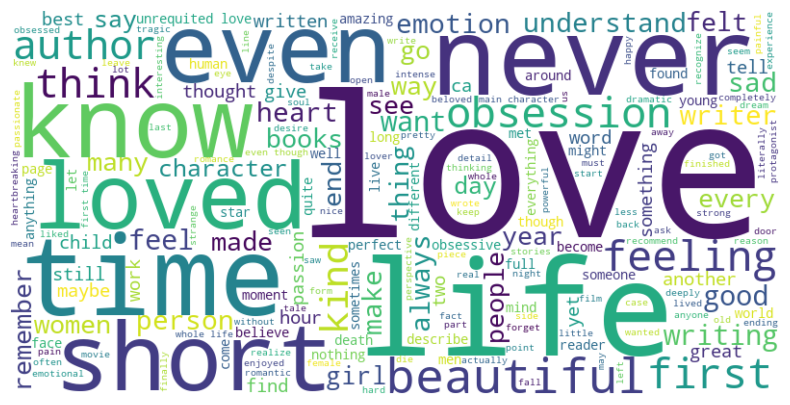

In [9]:
filtered_text_no_author=wordcloud(df)

Un conteo de palabras simple

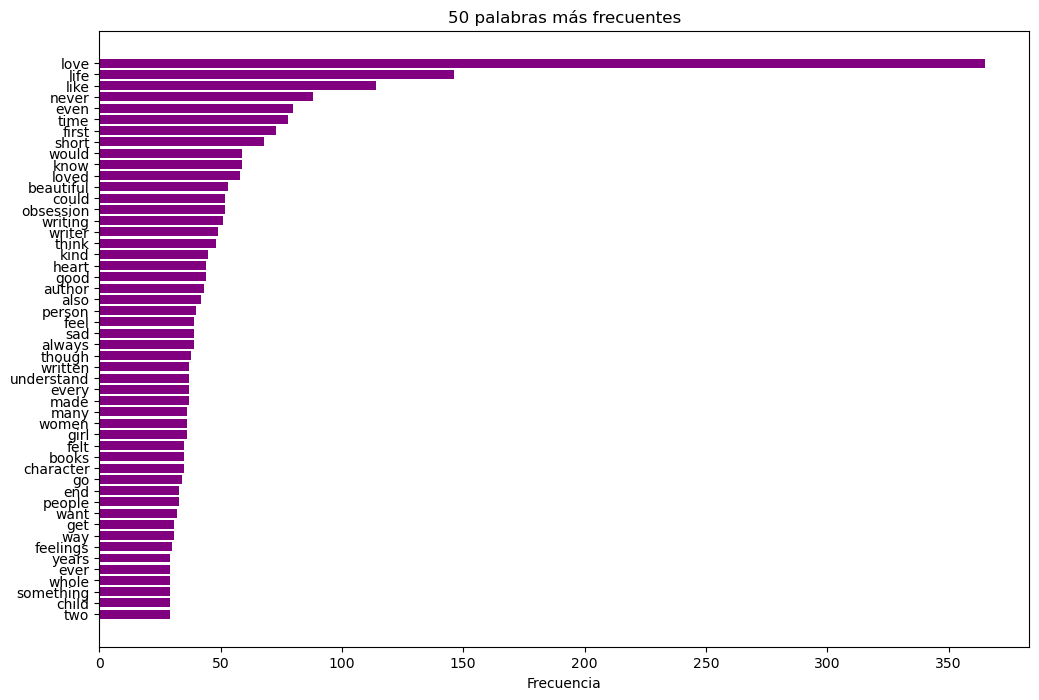

In [10]:
# Diagrama de árbol de palabras (Frecuencia)
freq_dist = FreqDist(filtered_text_no_author)
most_common_words = freq_dist.most_common(50)
words, counts = zip(*most_common_words)

plt.figure(figsize=(12, 8))
plt.barh(words, counts, color='purple')
plt.title('50 palabras más frecuentes')
plt.xlabel('Frecuencia')
plt.gca().invert_yaxis()
plt.show()

### 2.2. Análisis de sentimientos

Para averiguar la neutralidad de la reseña según la IA

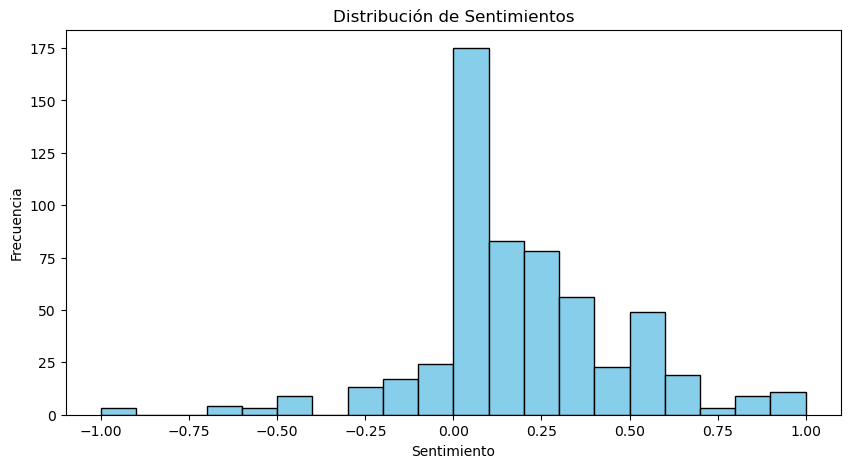

In [11]:
df['sentiment'] = df['reseña'].apply(lambda text: TextBlob(text).sentiment.polarity)
plt.figure(figsize=(10, 5))
plt.hist(df['sentiment'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribución de Sentimientos')
plt.xlabel('Sentimiento')
plt.ylabel('Frecuencia')
plt.show()

In [12]:
df_best=df[df['sentiment']>0.25]
df_best.sample(3)

,lector,fecha_reseña,reseña,puntuacion,obra,autor,sentiment
281,Riley Noel,2022-12-09,It was good. It was sad. I am not fully sure w...,4.0,A Letter from an Unknown Woman,Stefan Zweig,0.264444
518,Zay,2022-09-23,This one was a bullet train of emotions. I lau...,5.0,A Letter from an Unknown Woman,Stefan Zweig,0.300000
507,Mapeno,2022-06-22,"The story of this book is great, entertaining ...",5.0,A Letter from an Unknown Woman,Stefan Zweig,0.266667


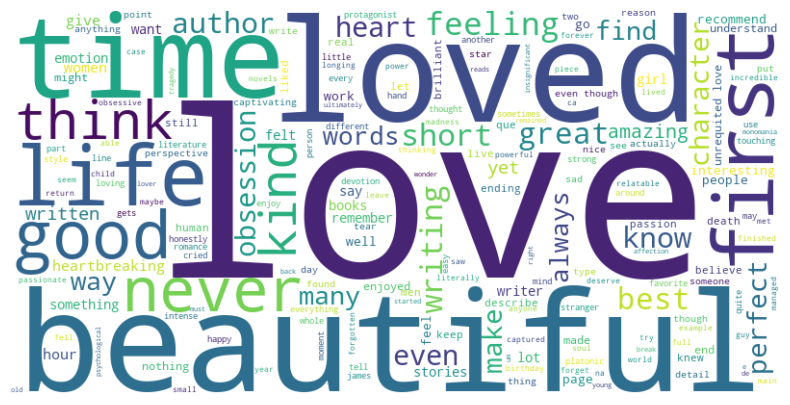

In [13]:
word_1=wordcloud(df_best)

In [14]:
df_worst=df[df['sentiment']<0].head(3)

In [15]:
df_worst.sample(3)

,lector,fecha_reseña,reseña,puntuacion,obra,autor,sentiment
21,Ligia,2021-07-28,so sad AND FOR WHAT,5.0,A Letter from an Unknown Woman,Stefan Zweig,-0.500000
15,George,2020-03-26,I am dazed and confused. What a book! Don't kn...,5.0,A Letter from an Unknown Woman,Stefan Zweig,-0.083333
1,BlackOxford,2017-11-30,Passive-Aggressive Revenge?\n\nOther than as a...,2.0,A Letter from an Unknown Woman,Stefan Zweig,-0.068333


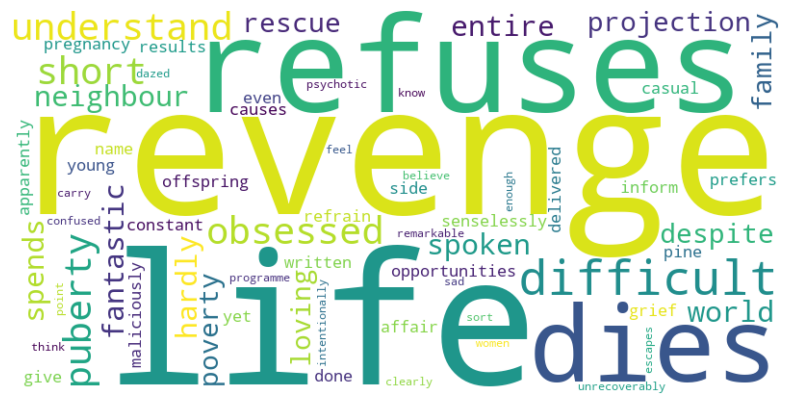

In [16]:
word_2=wordcloud(df_worst)

## 2.3. Serie de puntuaciones

C:\Users\User\AppData\Local\Temp\ipykernel_28752\4279592863.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_2=df_2.resample('M')['puntuacion'].mean().plot(title='Evolución Temporal de Puntuaciones')


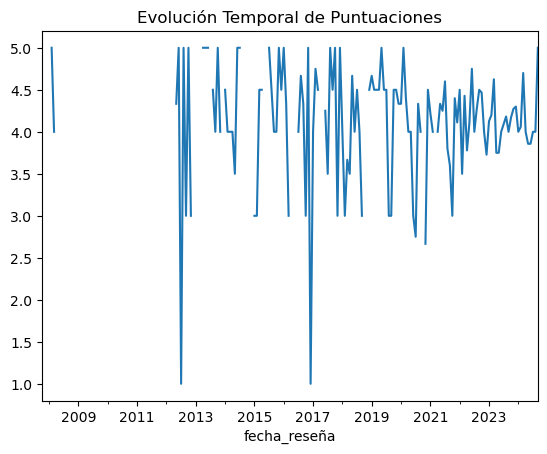

In [17]:
df['fecha_reseña'] = pd.to_datetime(df['fecha_reseña'])
df_2=df.set_index('fecha_reseña')
df_2=df_2.resample('M')['puntuacion'].mean().plot(title='Evolución Temporal de Puntuaciones')
plt.show()